Compare the EUV intensity profiles of a bright spot with the radio dynamic spectra

In [161]:
import warnings
warnings.filterwarnings('ignore')

import glob
import time
import requests
import argparse
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.dates import DateFormatter
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import AutoMinorLocator

from astropy import units as u
from astropy.visualization import ImageNormalize, PercentileInterval, SqrtStretch

import sunpy.map
from sunpy.net import Fido, attrs as a

import astrospice
import astropy.constants as const
from astropy.io import fits as pyfits
from solarmach import SolarMACH
import pyspedas
from pytplot import get_data

from astropy.time import Time, TimeDelta
from sunpy.coordinates import HeliographicStonyhurst, get_body_heliographic_stonyhurst

import os
import sys
# Construct the full path to the scripts directory
script_path = os.path.abspath('../../scripts')

# Add the scripts directory to sys.path
if script_path not in sys.path:
    sys.path.append(script_path)

import importlib
import solar_data_utils as myfuncs
# Reload to update with new changes
importlib.reload(myfuncs)

mpl.rcParams['date.epoch'] = '1970-01-01T00:00:00'
try:
    mdates.set_epoch('1970-01-01T00:00:00')
except:
    pass

#plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'


'''
SDO/AIA Instrument
===================
94 A : Flaring regions.
171 A: Quiet corona, upper transition region.
193 A: Corona and hot flare plasma.
211 A: Active region corona.
'''

root_dir = '/home/mnedal/repos/dias_work/20210918_paper/csv_files'
data_dir = '/home/mnedal/data'

In [11]:
t = pd.Timestamp('2021-09-18')

YEAR, MONTH, DAY = myfuncs.split_date(dt=t)
goes = myfuncs.fetch_xrs(data_dir=data_dir, dt=t, year=YEAR, month=MONTH, day=DAY)                                         # get GOES XRS data
wind_time, wind_freq, wind_data, wind_norm = myfuncs.fetch_waves(data_dir=data_dir, dt=t, year=YEAR, month=MONTH, day=DAY) # get WIND radio data
time_ste, freq_ste, data_ste_A, ste_norm = myfuncs.fetch_STAswaves(data_dir=data_dir, year=YEAR, month=MONTH, day=DAY)     # get STEREO radio data
df_psp, psp_norm = myfuncs.fetch_PSPfields(data_dir=data_dir, year=YEAR, month=MONTH, day=DAY, data_version=3)             # get PSP radio data

Wind/WAVES data exists locally.


In [12]:
# Load the EUV intensity profiles
df193 = pd.read_csv(f'{root_dir}/mean_intensities_193a.csv', names=['Datetime','avg_int'], index_col=0, skiprows=[0])
df193['Datetime'] = pd.to_datetime(df193['Datetime'])
df193.set_index('Datetime', inplace=True)

df211 = pd.read_csv(f'{root_dir}/mean_intensities_211a.csv', names=['Datetime','avg_int'], index_col=0, skiprows=[0])
df211['Datetime'] = pd.to_datetime(df211['Datetime'])
df211.set_index('Datetime', inplace=True)

PSP plot is ready.
STEREO plot is ready.
Wind plot is ready.
GOES plot is ready.
EUV intensity profiles are ready.


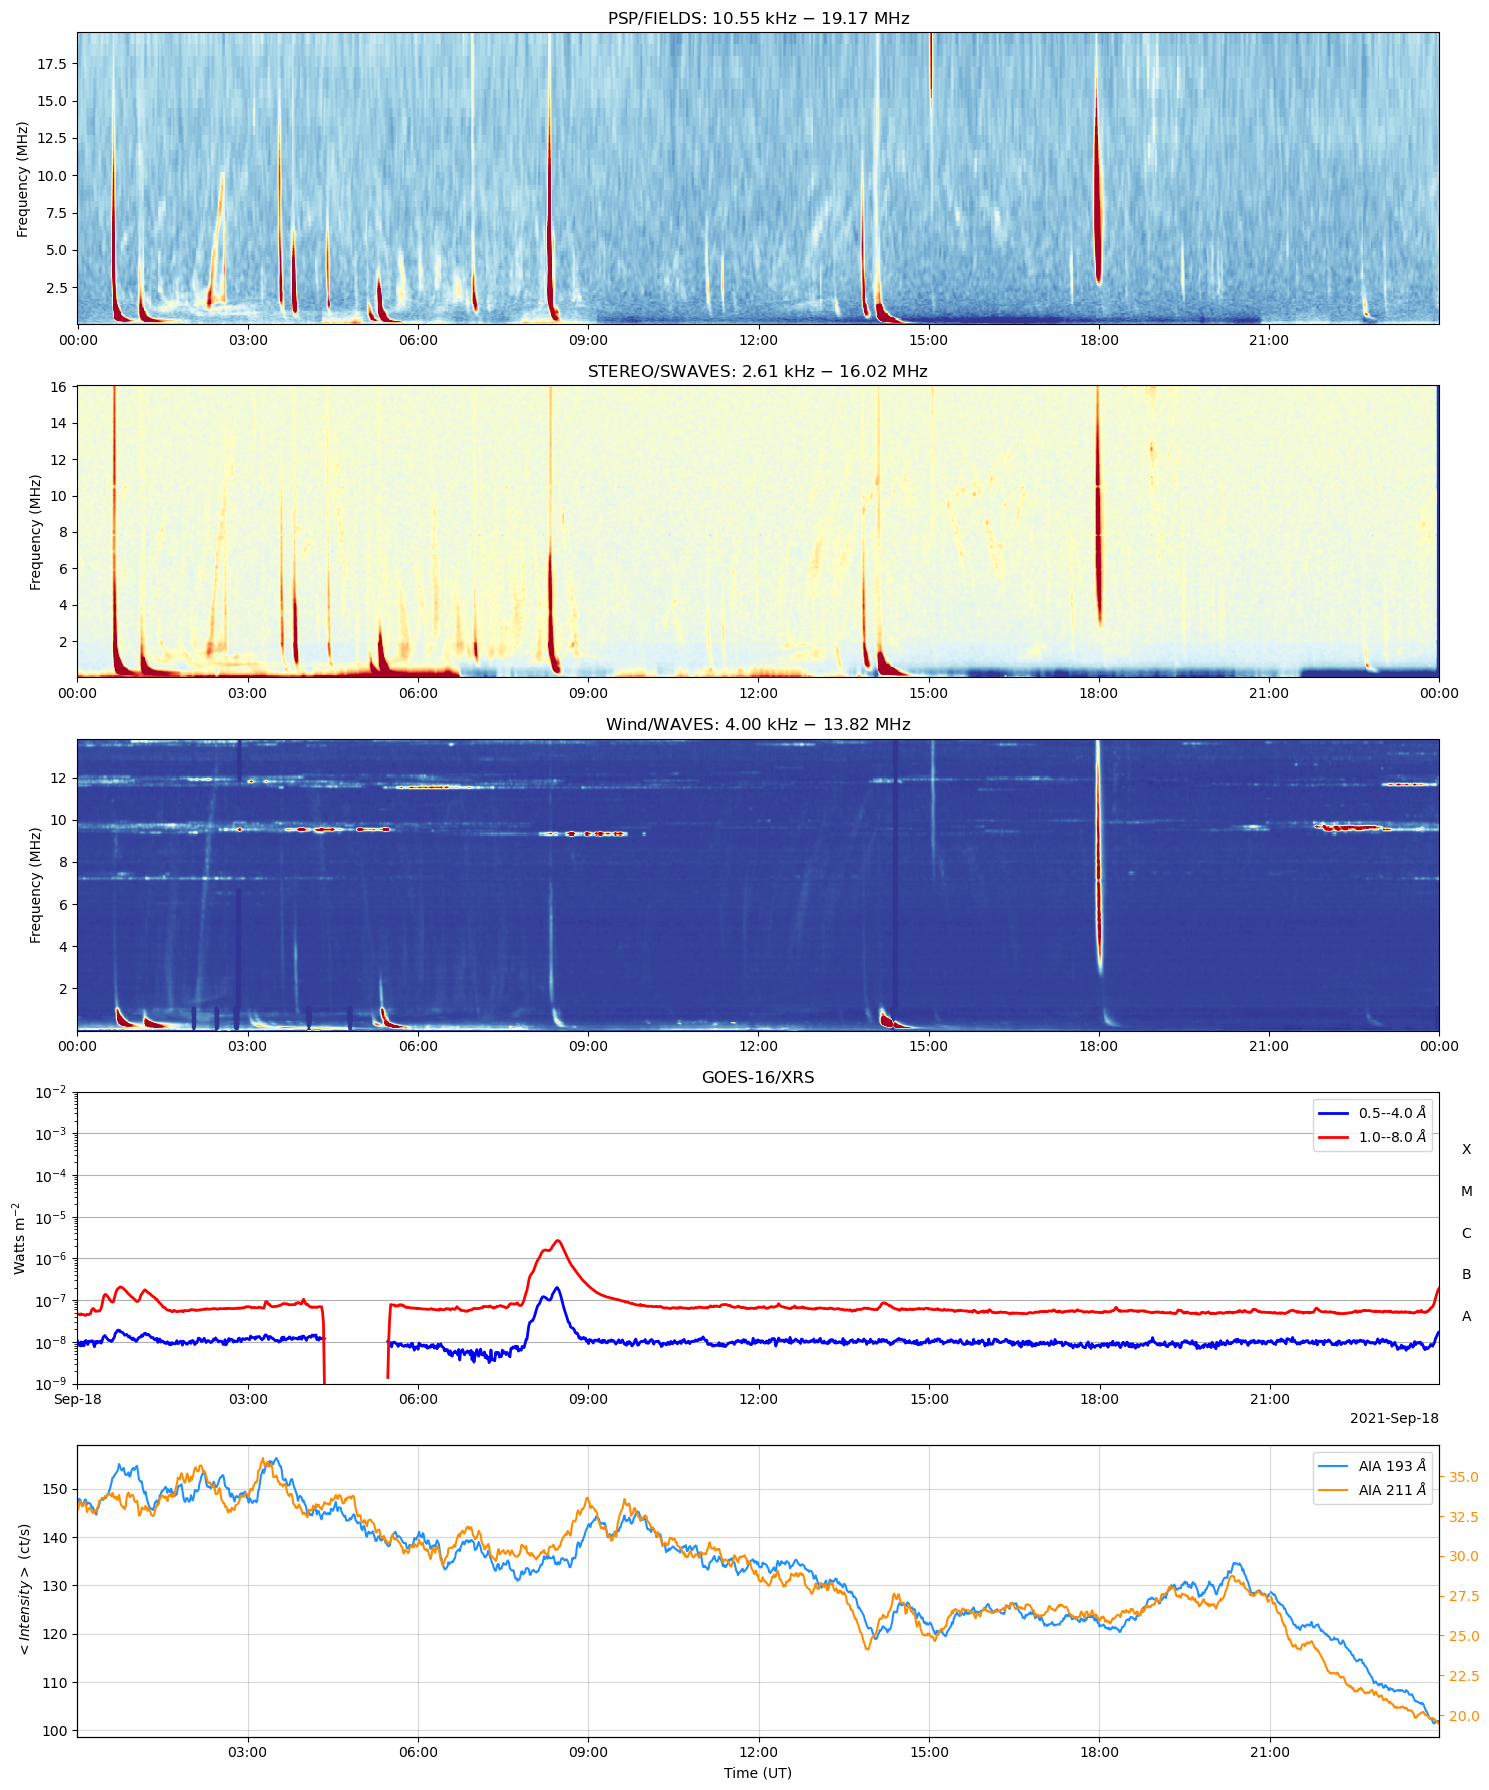

In [13]:
fig = plt.figure(figsize=[15,18])

ax1 = fig.add_subplot(511)
ax1.pcolormesh(df_psp.columns,
               df_psp.index,
               df_psp.values,
               norm=psp_norm,
               cmap='RdYlBu_r')
ax1.set_ylabel('Frequency (MHz)')
ax1.set_title(f"PSP/FIELDS: {df_psp.index[0]*1e3:.2f} kHz $-$ {df_psp.index[-1]:.2f} MHz")
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
print('PSP plot is ready.')

ax2 = fig.add_subplot(512)
ax2.pcolormesh(time_ste,
               freq_ste/1e3,
               data_ste_A,
               norm=ste_norm,
               cmap='RdYlBu_r')
ax2.grid(False)
ax2.set_ylabel('Frequency (MHz)')
ax2.set_title(f"STEREO/SWAVES: {freq_ste[0]:.2f} kHz $-$ {freq_ste[-1]/1e3:.2f} MHz")
ax2.xaxis_date()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
print('STEREO plot is ready.')

ax3 = fig.add_subplot(513)
ax3.pcolormesh(wind_time,
               wind_freq/1e3,
               wind_data.T,
               norm=wind_norm,
               cmap='RdYlBu_r')
ax3.set_ylabel('Frequency (MHz)')
ax3.set_title(f"Wind/WAVES: {wind_freq[0]:.2f} kHz $-$ {wind_freq[-1]/1e3:.2f} MHz")
ax3.xaxis_date()
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
print('Wind plot is ready.')

ax4 = fig.add_subplot(514)
goes.plot(axes=ax4)
ax4.set_xlim(left=mdates.date2num(pd.Timestamp(str(goes.time_range.start))),
                 right=mdates.date2num(pd.Timestamp(str(goes.time_range.end))))
ax4.set_title(f"{goes.observatory}/{goes.source.upper()}")
print('GOES plot is ready.')

ax5 = fig.add_subplot(515)
ax5.plot(df193.index, df193['avg_int'], color='dodgerblue', label=r'AIA 193 $\AA$')
ax55 = ax5.twinx()
ax55.plot(df211.index, df211['avg_int'], color='darkorange', label=r'AIA 211 $\AA$')

# Change color of ticks and numbers on the right y-axis
ax55.tick_params(axis='y', colors='darkorange')
ax5.set_xlabel('Time (UT)')
ax5.set_ylabel(r'$<Intensity>$ (ct/s)')
ax5.grid(alpha=0.5)
ax5.xaxis_date()
ax5.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax5.set_xlim(df193.index[0], df193.index[-1])

# Combine legends into one box
lines, labels = ax5.get_legend_handles_labels()
lines2, labels2 = ax55.get_legend_handles_labels()
ax5.legend(lines + lines2, labels + labels2, loc='upper right')
print('EUV intensity profiles are ready.')

fig.tight_layout()
# fig.savefig(f'./multiwavelength_comparison_{t.date()}.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# Load the EUV intensity profiles, segments
aia_channel = 94

df = pd.read_csv(f'{root_dir}/mean_intensities_segments_{aia_channel}a.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)

# Replace values meeting condition with NaN in all columns
df = df.applymap(lambda x: np.nan if x < 0.5 else x)

# Pick this column to plot
col = 'avg_int_seg1'

df.head()

avg_int_seg1  avg_int_seg2  avg_int_seg3  \
datetime                                                            
2021-09-18 00:00:11.120      1.235434      1.636264      1.517153   
2021-09-18 00:01:11.120      1.222288      1.622843      1.529998   
2021-09-18 00:02:11.120      1.245311      1.647665      1.533096   
2021-09-18 00:03:11.120      1.246935      1.648632      1.517583   
2021-09-18 00:04:11.120      1.240321      1.643477      1.531793   

                         avg_int_seg4  avg_int_seg5  avg_int_seg6  \
datetime                                                            
2021-09-18 00:00:11.120      1.238402      2.890360      1.847120   
2021-09-18 00:01:11.120      1.249259      2.880600      1.840126   
2021-09-18 00:02:11.120      1.249659      2.901950      1.858446   
2021-09-18 00:03:11.120      1.239351      2.898444      1.861900   
2021-09-18 00:04:11.120      1.250720      2.891307      1.856512   

                         avg_int_seg7  avg_int_seg8  avg_int_seg9  \
datetime                                                            
2021-09-18 00:00:11.120      1.790558      2.557709      3.136731   
2021-09-18 00:01:11.120      1.811736      2.577692      3.128582   
2021-09-18 00:02:11.120      1.812820      2.583537      3.113945   
2021-09-18 00:03:11.120      1.797461      2.567969      3.133723   
2021-09-18 00:04:11.120      1.804577      2.569124      3.141242   

                         avg_int_seg10  avg_int_seg11  avg_int_seg12  \
datetime                                                               
2021-09-18 00:00:11.120       1.764011       1.657346       2.625050   
2021-09-18 00:01:11.120       1.758309       1.674863       2.644898   
2021-09-18 00:02:11.120       1.747620       1.662800       2.629456   
2021-09-18 00:03:11.120       1.762916       1.663107       2.639077   
2021-09-18 00:04:11.120       1.772166       1.671308       2.638855   

                         avg_int_seg13  avg_int_seg14  avg_int_seg15  \
datetime                                                               
2021-09-18 00:00:11.120       1.897461       1.860995       1.642004   
2021-09-18 00:01:11.120       1.901943       1.865525       1.647437   
2021-09-18 00:02:11.120       1.889088       1.852806       1.638788   
2021-09-18 00:03:11.120       1.907857       1.871970       1.636915   
2021-09-18 00:04:11.120       1.905009       1.869384       1.637743   

                         avg_int_seg16  
datetime                                
2021-09-18 00:00:11.120       1.631956  
2021-09-18 00:01:11.120       1.636960  
2021-09-18 00:02:11.120       1.633213  
2021-09-18 00:03:11.120       1.625035  
2021-09-18 00:04:11.120       1.629186

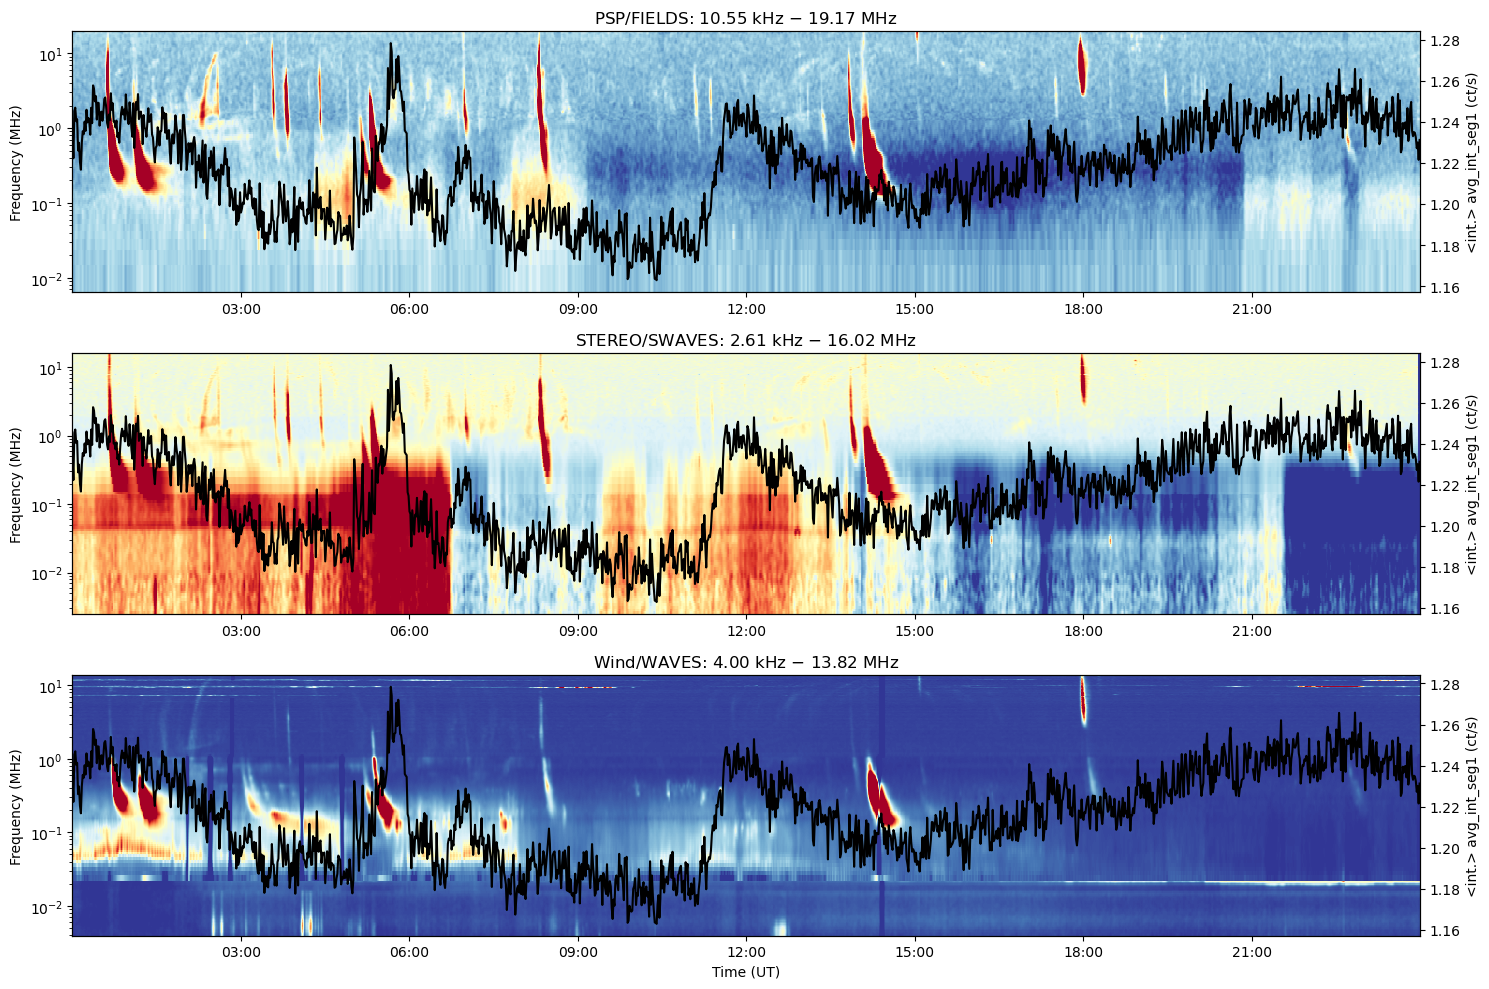

In [16]:
fig = plt.figure(figsize=[15,10])

ax = fig.add_subplot(311)
ax.pcolormesh(df_psp.columns,
               df_psp.index,
               df_psp.values,
               norm=psp_norm,
               cmap='RdYlBu_r')
ax.set_yscale('log')
ax.set_ylabel('Frequency (MHz)')
ax.set_title(f"PSP/FIELDS: {df_psp.index[0]*1e3:.2f} kHz $-$ {df_psp.index[-1]:.2f} MHz")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

axx = ax.twinx()
axx.plot(df.index, df[col], color='k')
axx.set_ylabel(f'<int.> {col} (ct/s)')
axx.set_xlim(df.index[0], df.index[-1])

ax = fig.add_subplot(312)
ax.pcolormesh(time_ste,
               freq_ste/1e3,
               data_ste_A,
               norm=ste_norm,
               cmap='RdYlBu_r')
ax.set_yscale('log')
ax.set_ylabel('Frequency (MHz)')
ax.set_title(f"STEREO/SWAVES: {freq_ste[0]:.2f} kHz $-$ {freq_ste[-1]/1e3:.2f} MHz")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

axx = ax.twinx()
axx.plot(df.index, df[col], color='k')
axx.set_ylabel(f'<int.> {col} (ct/s)')
axx.set_xlim(df.index[0], df.index[-1])

ax = fig.add_subplot(313)
ax.pcolormesh(wind_time,
               wind_freq/1e3,
               wind_data.T,
               norm=wind_norm,
               cmap='RdYlBu_r')
ax.set_yscale('log')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_title(f"Wind/WAVES: {wind_freq[0]:.2f} kHz $-$ {wind_freq[-1]/1e3:.2f} MHz")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

axx = ax.twinx()
axx.plot(df.index, df[col], color='k')
axx.set_ylabel(f'<int.> {col} (ct/s)')
axx.set_xlim(df.index[0], df.index[-1])

fig.tight_layout()
plt.show()

In [ ]:
# Doing a for loop ...
for col in df.columns:
    print(f'Doing {col} ...')
    
    fig = plt.figure(figsize=[15,10])

    ax = fig.add_subplot(311)
    ax.pcolormesh(df_psp.columns,
                   df_psp.index,
                   df_psp.values,
                   norm=psp_norm,
                   cmap='RdYlBu_r')
    ax.set_yscale('log')
    ax.set_ylabel('Frequency (MHz)')
    ax.set_title(f"PSP/FIELDS: {df_psp.index[0]*1e3:.2f} kHz $-$ {df_psp.index[-1]:.2f} MHz")
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    axx = ax.twinx()
    axx.plot(df.index, df[col], color='k')
    axx.set_ylabel(f'<int.> {col} (ct/s)')
    axx.set_xlim(df.index[0], df.index[-1])

    ax = fig.add_subplot(312)
    ax.pcolormesh(time_ste,
                   freq_ste/1e3,
                   data_ste_A,
                   norm=ste_norm,
                   cmap='RdYlBu_r')
    ax.set_yscale('log')
    ax.set_ylabel('Frequency (MHz)')
    ax.set_title(f"STEREO/SWAVES: {freq_ste[0]:.2f} kHz $-$ {freq_ste[-1]/1e3:.2f} MHz")
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    axx = ax.twinx()
    axx.plot(df.index, df[col], color='k')
    axx.set_ylabel(f'<int.> {col} (ct/s)')
    axx.set_xlim(df.index[0], df.index[-1])

    ax = fig.add_subplot(313)
    ax.pcolormesh(wind_time,
                   wind_freq/1e3,
                   wind_data.T,
                   norm=wind_norm,
                   cmap='RdYlBu_r')
    ax.set_yscale('log')
    ax.set_xlabel('Time (UT)')
    ax.set_ylabel('Frequency (MHz)')
    ax.set_title(f"Wind/WAVES: {wind_freq[0]:.2f} kHz $-$ {wind_freq[-1]/1e3:.2f} MHz")
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    axx = ax.twinx()
    axx.plot(df.index, df[col], color='k')
    axx.set_ylabel(f'<int.> {col} (ct/s)')
    axx.set_xlim(df.index[0], df.index[-1])

    fig.tight_layout()
    # fig.savefig(f'./plots/multiwavelength_comparison_{t.date()}_{col}_{aia_channel}a.png', format='png', dpi=300, bbox_inches='tight')
    plt.close()

In [20]:
frequencies = [0.2, 0.5, 1, 3.5, 7.5, 12.5, 17.5]

channels = [myfuncs.nearest(df_psp.index, x) for x in frequencies]
print(channels)

[0.19687500596046448, 0.486328125, 1.013671875, 3.5250000953674316, 7.425000190734863, 12.421875, 17.625]


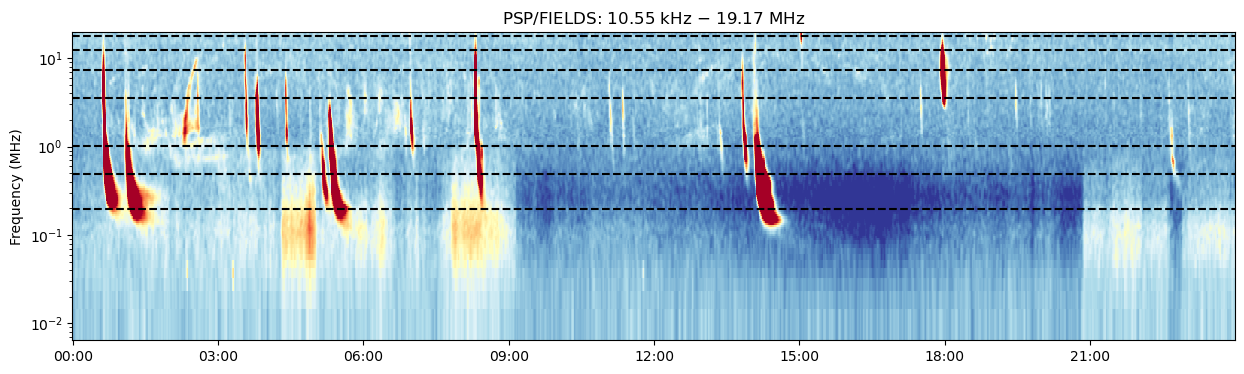

In [21]:
# skipped_channels = int(len(df_psp.index[df_psp.index > 1])/7)
# channels = df_psp.index[::skipped_channels]
# print(channels)

fig = plt.figure(figsize=[15,4])

ax = fig.add_subplot(111)
ax.pcolormesh(df_psp.columns,
               df_psp.index,
               df_psp.values,
               norm=psp_norm,
               cmap='RdYlBu_r')

for channel in channels:
    ax.axhline(y=channel, color='k', linestyle='--')

ax.set_yscale('log')
ax.set_ylabel('Frequency (MHz)')
ax.set_title(f"PSP/FIELDS: {df_psp.index[0]*1e3:.2f} kHz $-$ {df_psp.index[-1]:.2f} MHz")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()

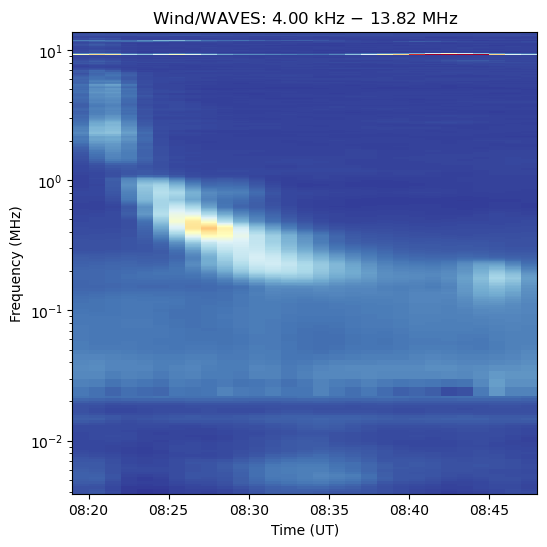

In [22]:
fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111)
ax.pcolormesh(wind_time,
               wind_freq/1e3,
               wind_data.T,
               norm=wind_norm,
               cmap='RdYlBu_r')
ax.set_yscale('log')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_title(f"Wind/WAVES: {wind_freq[0]:.2f} kHz $-$ {wind_freq[-1]/1e3:.2f} MHz")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(left=pd.Timestamp('2021-09-18 08:19'),
            right=pd.Timestamp('2021-09-18 08:48'))
plt.show()

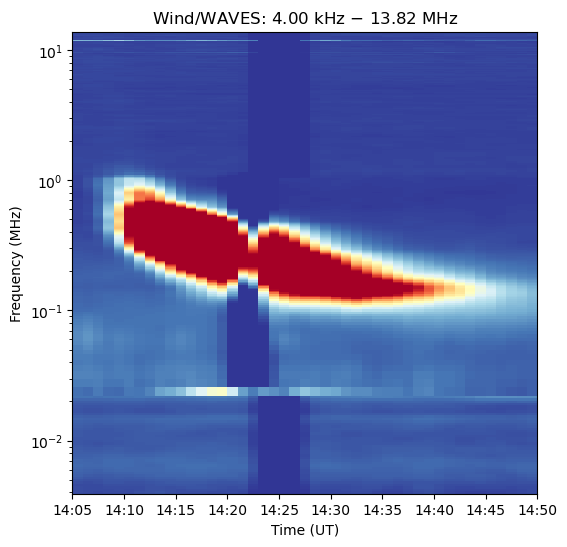

In [23]:
fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111)
ax.pcolormesh(wind_time,
               wind_freq/1e3,
               wind_data.T,
               norm=wind_norm,
               cmap='RdYlBu_r')
ax.set_yscale('log')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_title(f"Wind/WAVES: {wind_freq[0]:.2f} kHz $-$ {wind_freq[-1]/1e3:.2f} MHz")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(left=pd.Timestamp('2021-09-18 14:05'),
            right=pd.Timestamp('2021-09-18 14:50'))
plt.show()

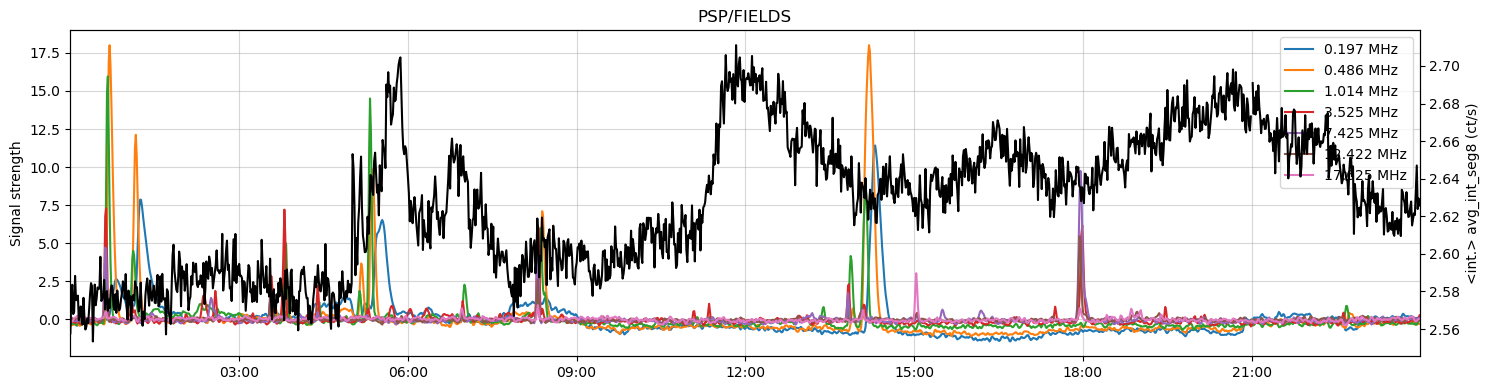

In [24]:
fig = plt.figure(figsize=[15,4])
ax = fig.add_subplot(111)

for channel in channels:
    ax.plot(df_psp.columns, df_psp.loc[channel], label=f'{channel:.3f} MHz')

axx = ax.twinx()
axx.plot(df.index, df[col], color='k')
axx.set_ylabel(f'<int.> {col} (ct/s)')

ax.legend()
ax.grid(alpha=0.5)
ax.set_ylabel('Signal strength')
ax.set_title('PSP/FIELDS')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(df_psp.columns[0], df_psp.columns[-1])
fig.tight_layout()
plt.show()

In [145]:
# Doing a for loop ...
for col in df.columns:
    print(f'Doing {col} ...')
    
    fig = plt.figure(figsize=[15,8])
    
    ax = fig.add_subplot(211)
    for channel in channels:
        ax.plot(df_psp.columns, df_psp.loc[channel], label=f'{channel:.3f} MHz')

    axx = ax.twinx()
    axx.plot(df.index, df[col], color='k')
    axx.set_ylabel(f'<int.> {col} (ct/s)')
    
    ax.legend()
    ax.grid(alpha=0.5)
    ax.set_ylabel('Signal strength')
    ax.set_title(f"PSP/FIELDS: {df_psp.index[0]*1e3:.2f} kHz $-$ {df_psp.index[-1]:.2f} MHz")
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.set_xlim(df_psp.columns[0], df_psp.columns[-1])
    
    ax = fig.add_subplot(212)
    ax.pcolormesh(df_psp.columns,
                   df_psp.index,
                   df_psp.values,
                   norm=psp_norm,
                   cmap='RdYlBu_r')
    for channel in channels:
        ax.axhline(y=channel, color='white', linestyle='--')
    
    ax.set_yscale('log')
    ax.set_xlabel('Time (UT)')
    ax.set_ylabel('Frequency (MHz)')
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    axx = ax.twinx()
    axx.plot(df.index, df[col], color='k')
    axx.set_ylabel(f'<int.> {col} (ct/s)')
    axx.set_xlim(df.index[0], df.index[-1])
    
    fig.tight_layout()
    # fig.savefig(f'./plots/psp_comparison_{t.date()}_{col}_{aia_channel}a.png', format='png', dpi=300, bbox_inches='tight')
    plt.close()

Doing avg_int_seg1 ...
Doing avg_int_seg2 ...
Doing avg_int_seg3 ...
Doing avg_int_seg4 ...
Doing avg_int_seg5 ...
Doing avg_int_seg6 ...
Doing avg_int_seg7 ...
Doing avg_int_seg8 ...
Doing avg_int_seg9 ...
Doing avg_int_seg10 ...
Doing avg_int_seg11 ...
Doing avg_int_seg12 ...
Doing avg_int_seg13 ...
Doing avg_int_seg14 ...
Doing avg_int_seg15 ...
Doing avg_int_seg16 ...


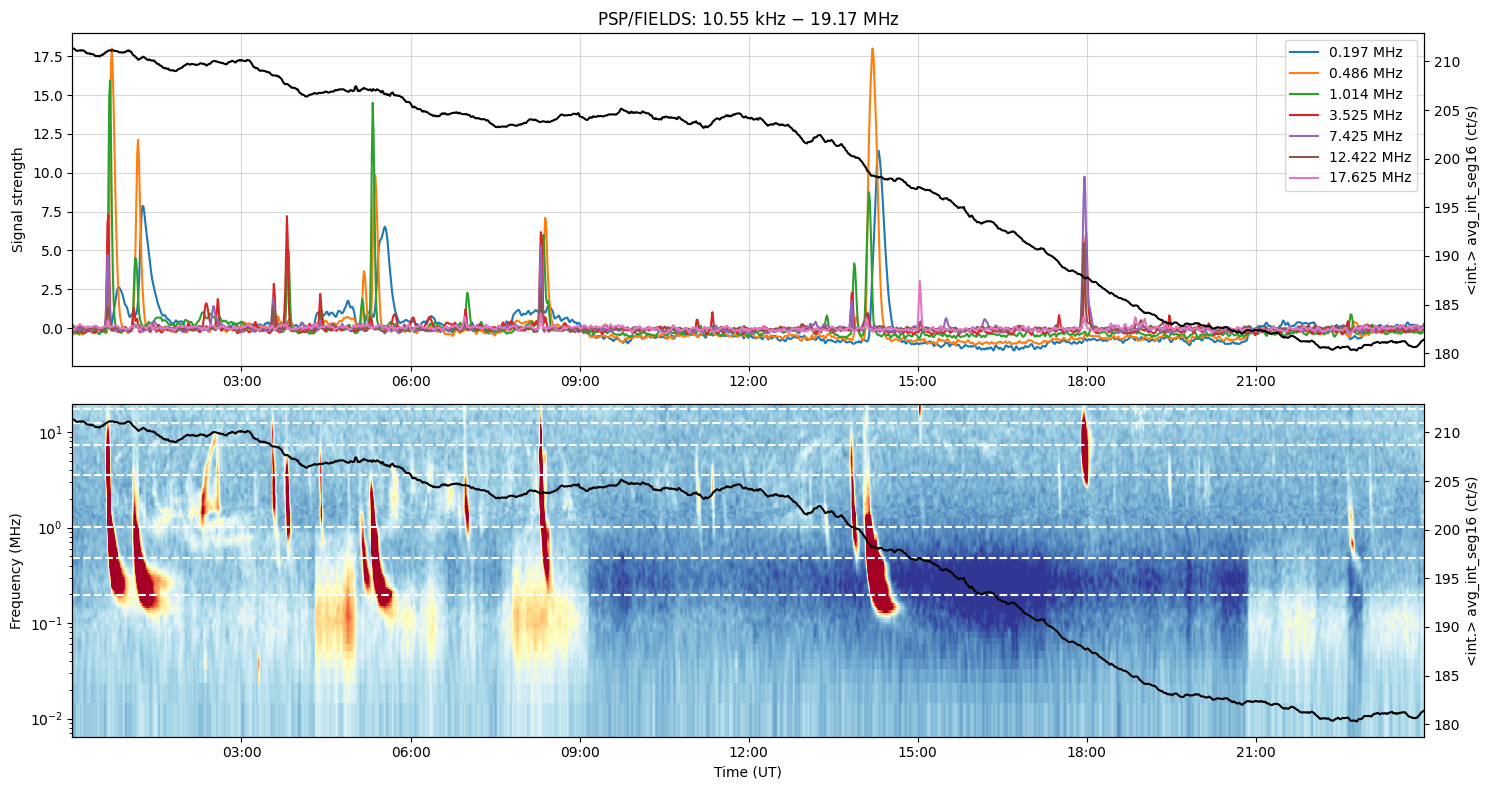

In [132]:
# Test

fig = plt.figure(figsize=[15,8])

ax = fig.add_subplot(211)
for channel in channels:
    ax.plot(df_psp.columns, df_psp.loc[channel], label=f'{channel:.3f} MHz')

axx = ax.twinx()
axx.plot(df.index, df[col], color='k')
axx.set_ylabel(f'<int.> {col} (ct/s)')

ax.legend()
ax.grid(alpha=0.5)
ax.set_ylabel('Signal strength')
ax.set_title(f"PSP/FIELDS: {df_psp.index[0]*1e3:.2f} kHz $-$ {df_psp.index[-1]:.2f} MHz")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(df_psp.columns[0], df_psp.columns[-1])

ax = fig.add_subplot(212)
ax.pcolormesh(df_psp.columns,
               df_psp.index,
               df_psp.values,
               norm=psp_norm,
               cmap='RdYlBu_r')
for channel in channels:
    ax.axhline(y=channel, color='white', linestyle='--')

ax.set_yscale('log')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

axx = ax.twinx()
axx.plot(df.index, df[col], color='k')
axx.set_ylabel(f'<int.> {col} (ct/s)')
axx.set_xlim(df.index[0], df.index[-1])

fig.tight_layout()
plt.show()

In [ ]:
# Doing a for loop ...
for col in df.columns:
    print(f'Doing {col} ...')
    
    fig = plt.figure(figsize=[15,4])
    ax = fig.add_subplot(111)

    for channel in channels:
        ax.plot(df_psp.columns, df_psp.loc[channel], label=f'{channel:.3f} MHz')

    axx = ax.twinx()
    axx.plot(df.index, df[col], color='k')
    axx.set_ylabel(f'<int.> {col} (ct/s)')
    
    ax.legend()
    ax.grid(alpha=0.5)
    ax.set_ylabel('Signal strength')
    ax.set_title(f"PSP/FIELDS: {df_psp.index[0]*1e3:.2f} kHz $-$ {df_psp.index[-1]:.2f} MHz")
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.set_xlim(df_psp.columns[0], df_psp.columns[-1])
    fig.tight_layout()
    fig.savefig(f'./plots/psp_comparison_{t.date()}_{col}_193a.png', format='png', dpi=300, bbox_inches='tight')
    plt.close()

In [ ]:
# fig = plt.figure(figsize=[15,10])

# ax = fig.add_subplot(311)
# ax.pcolormesh(df_psp.columns,
#                df_psp.index,
#                df_psp.values,
#                norm=psp_norm,
#                cmap='RdYlBu_r')
# ax.set_yscale('log')
# ax.set_ylabel('Frequency (MHz)')
# ax.set_title(f"PSP/FIELDS: {df_psp.index[0]*1e3:.2f} kHz $-$ {df_psp.index[-1]:.2f} MHz")
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# axx = ax.twinx()
# axx.plot(df.index, df[col], color='k')
# axx.set_ylabel(f'<int.> {col} (ct/s)')
# axx.set_xlim(df.index[0], df.index[-1])

# ax = fig.add_subplot(312)
# ax.pcolormesh(time_ste,
#                freq_ste/1e3,
#                data_ste_A,
#                norm=ste_norm,
#                cmap='RdYlBu_r')
# ax.set_yscale('log')
# ax.set_ylabel('Frequency (MHz)')
# ax.set_title(f"STEREO/SWAVES: {freq_ste[0]:.2f} kHz $-$ {freq_ste[-1]/1e3:.2f} MHz")
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# axx = ax.twinx()
# axx.plot(df.index, df[col], color='k')
# axx.set_ylabel(f'<int.> {col} (ct/s)')
# axx.set_xlim(df.index[0], df.index[-1])

# ax = fig.add_subplot(313)
# ax.pcolormesh(wind_time,
#                wind_freq/1e3,
#                wind_data.T,
#                norm=wind_norm,
#                cmap='RdYlBu_r')
# ax.set_yscale('log')
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.set_title(f"Wind/WAVES: {wind_freq[0]:.2f} kHz $-$ {wind_freq[-1]/1e3:.2f} MHz")
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# axx = ax.twinx()
# axx.plot(df.index, df[col], color='k')
# axx.set_ylabel(f'<int.> {col} (ct/s)')
# axx.set_xlim(df.index[0], df.index[-1])

# fig.tight_layout()
# plt.show()

# Plot AIA 193 and 94 $A^o$ together ...

In [25]:
# Load the EUV intensity profiles, segments
df_94 = pd.read_csv(f'{root_dir}/mean_intensities_segments_94a.csv')
df_94['datetime'] = pd.to_datetime(df_94['datetime'])
df_94.set_index('datetime', inplace=True)
df_94.drop('Unnamed: 0', axis=1, inplace=True)

df_193 = pd.read_csv(f'{root_dir}/mean_intensities_segments_193a.csv')
df_193['datetime'] = pd.to_datetime(df_193['datetime'])
df_193.set_index('datetime', inplace=True)
df_193.drop('Unnamed: 0', axis=1, inplace=True)

# Replace values meeting condition with NaN in all columns
df_94 = df_94.applymap(lambda x: np.nan if x < 0.5 else x)
df_193 = df_193.applymap(lambda x: np.nan if x < 0.5 else x)

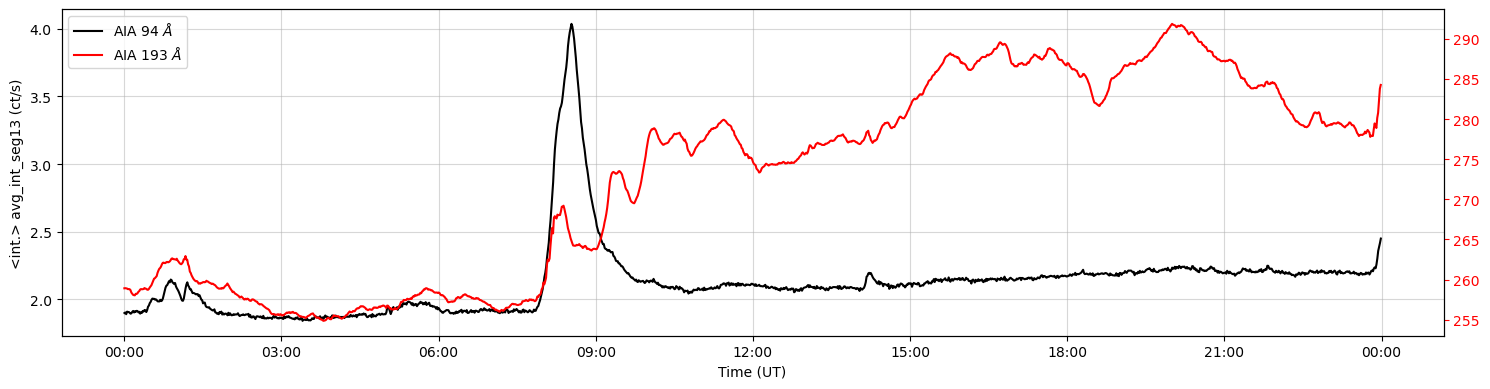

In [26]:
# Pick this column to plot
col = 'avg_int_seg13'

fig = plt.figure(figsize=[15,4])
ax = fig.add_subplot(111)

line94, = ax.plot(df_94.index, df_94[col], color='k', label='AIA 94 $\AA$')
axx = ax.twinx()
line193, = axx.plot(df_193.index, df_193[col], color='r', label='AIA 193 $\AA$')

# Set y-axis tick labels color to match line color
axx.tick_params(axis='y', colors='r')

# Combine legends
lines = [line94, line193]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='upper left')

ax.set_xlabel('Time (UT)')
ax.set_ylabel(f'<int.> {col} (ct/s)')
ax.grid(alpha=0.5)
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

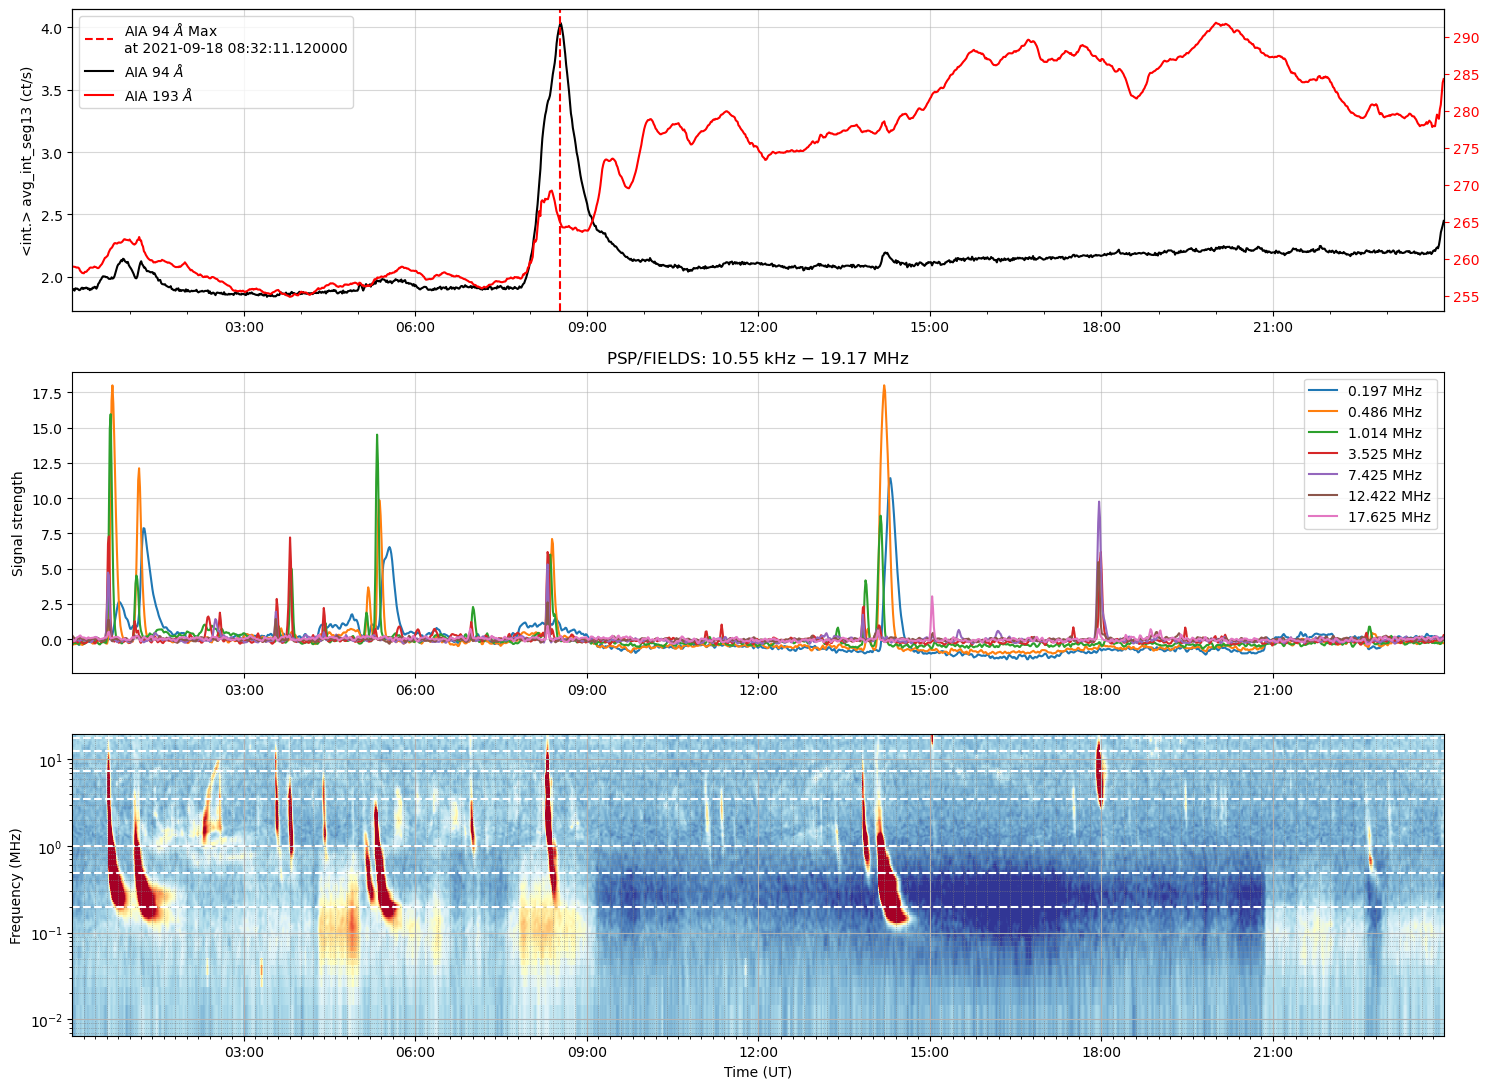

In [27]:
# Test
fig = plt.figure(figsize=[15,11])

ax = fig.add_subplot(311)
line94, = ax.plot(df_94.index, df_94[col], color='k', label='AIA 94 $\AA$')
axx = ax.twinx()
line193, = axx.plot(df_193.index, df_193[col], color='r', label='AIA 193 $\AA$')

# Find the index of the maximum value
max_index = np.argmax(df_94[col])
max_value = df_94[col][max_index]
max_time = df_94.index[max_index]
# Draw a vertical line at the time step with the maximum value
max_line = ax.axvline(x=max_time, color='red', linestyle='--', label=f'AIA 94 $\AA$ Max\nat {max_time}')

axx.tick_params(axis='y', colors='r') # Set y-axis tick labels color to match line color
lines = [max_line, line94, line193] # Combine legends
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='upper left')
ax.set_ylabel(f'<int.> {col} (ct/s)')
ax.grid(alpha=0.5)
ax.xaxis.set_minor_locator(AutoMinorLocator(n=3))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(df_193.index[0], df_193.index[-1])
# ax.set_xlim(left=pd.Timestamp('2021-09-18 07:45'), right=pd.Timestamp('2021-09-18 09:30'))

ax = fig.add_subplot(312)
for channel in channels:
    ax.plot(df_psp.columns, df_psp.loc[channel], label=f'{channel:.3f} MHz')
ax.legend()
ax.grid(alpha=0.5)
ax.set_ylabel('Signal strength')
ax.set_title(f"PSP/FIELDS: {df_psp.index[0]*1e3:.2f} kHz $-$ {df_psp.index[-1]:.2f} MHz")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(df_psp.columns[0], df_psp.columns[-1])
# ax.set_xlim(left=pd.Timestamp('2021-09-18 07:45'), right=pd.Timestamp('2021-09-18 09:30'))


ax = fig.add_subplot(313)
ax.pcolormesh(df_psp.columns,
               df_psp.index,
               df_psp.values,
               norm=psp_norm,
               cmap='RdYlBu_r')
for channel in channels:
    ax.axhline(y=channel, color='white', linestyle='--')

ax.set_yscale('log')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.grid()

plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

ax.xaxis.set_minor_locator(AutoMinorLocator(n=15))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(df_psp.columns[0], df_psp.columns[-1])
# ax.set_xlim(left=pd.Timestamp('2021-09-18 07:45'), right=pd.Timestamp('2021-09-18 09:30'))

fig.tight_layout()
plt.show()

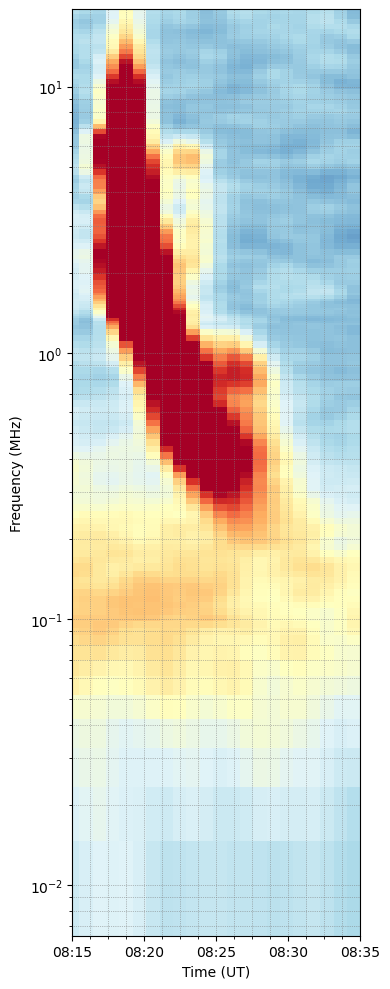

In [28]:
fig = plt.figure(figsize=[4,10])
ax = fig.add_subplot(111)
ax.pcolormesh(df_psp.columns, df_psp.index, df_psp.values, norm=psp_norm, cmap='RdYlBu_r')
ax.set_yscale('log')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.minorticks_on()
ax.grid(which='both', linestyle=':', linewidth='0.5', color='gray')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(left=pd.Timestamp('2021-09-18 08:15'), right=pd.Timestamp('2021-09-18 08:35'))
fig.tight_layout()
plt.show()

## Plot NDA with PSP

In [29]:
date = '2021-09-18'
year, month, day = date.split('-')
nda_files = sorted(glob.glob(f'{data_dir}/NDA/NDA_{day}{month}{year}_*.fits'))
print(nda_files)

['/home/mnedal/data/NDA/NDA_18092021_1_07_45_19_15_32_56.fits']


In [30]:
nda_data = pyfits.open(nda_files[0])
### define x and y axes
nda_freq = pd.DataFrame(nda_data[3].data).values.reshape(-1)
nda_time = pd.DataFrame(nda_data[4].data).values.reshape(-1)
nda_arr = nda_data[1].data[:, :-1]
# nda_arr = nda_data[2].data[:, :-1]

datetime_obj_start = nda_data[0].header['DATE-OBS'] + ' ' + nda_data[0].header['TIME-OBS']
datetime_obj_end   = nda_data[0].header['DATE-OBS'] + ' ' + nda_data[0].header['TIME-END']

start_obs_time = datetime.strptime(datetime_obj_start, '%d/%m/%Y %H:%M:%S')
end_obs_time   = datetime.strptime(datetime_obj_end, '%d/%m/%Y %H:%M:%S')

# Convert time data to datetime objects
time_data = nda_data[4].data
datetimes_list = [pd.Timestamp('2021-09-18 00:00:00') + timedelta(seconds=float(time[0])) for time in time_data]

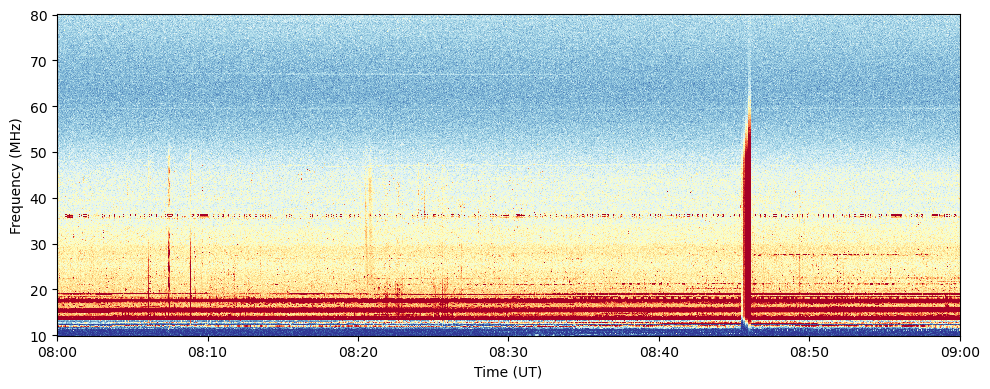

In [31]:
fig = plt.figure(figsize=[10,4])
ax = fig.add_subplot(111)
ax.pcolormesh(datetimes_list, nda_freq, nda_arr,
              vmin=np.percentile(nda_arr, 1),
              vmax=np.percentile(nda_arr, 95),
              cmap='RdYlBu_r')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(left=pd.Timestamp('2021-09-18 08:00'), right=pd.Timestamp('2021-09-18 09:00'))
fig.tight_layout()
plt.show()

In [32]:
# construct a dataframe for NDA data
df_nda = pd.DataFrame(nda_arr.astype('float64'))
df_nda.columns = pd.to_datetime(datetimes_list)
df_nda.insert(loc=0, column='Frequency', value=list(nda_freq))
df_nda.set_index(['Frequency'], inplace=True)

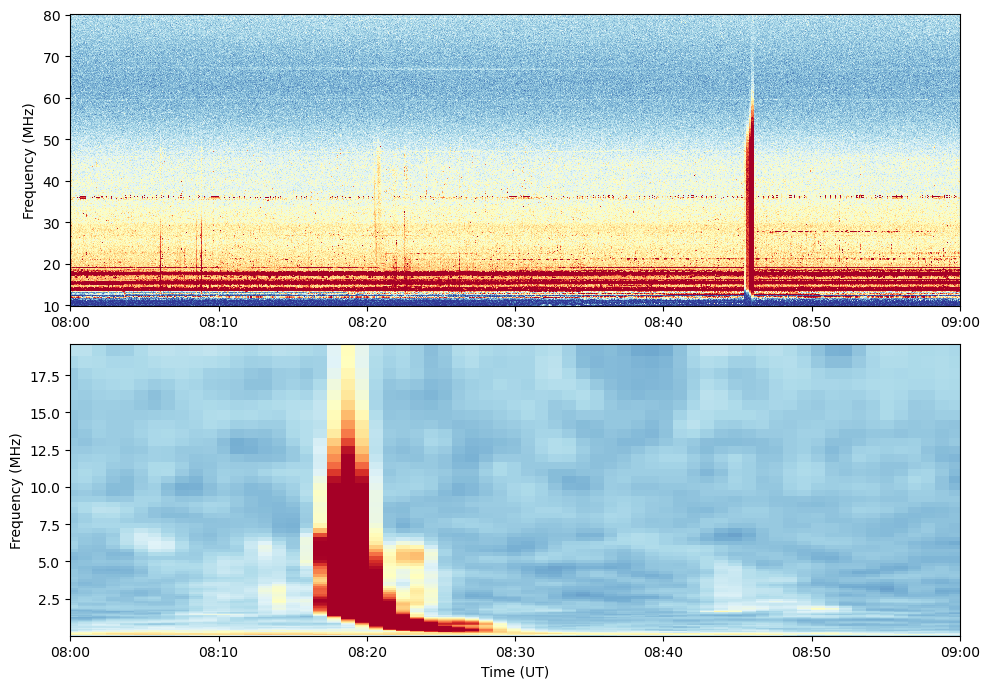

In [33]:
fig = plt.figure(figsize=[10,7])

ax = fig.add_subplot(211)
ax.pcolormesh(df_nda.columns,
              df_nda.index,
              df_nda.values,
              vmin=np.percentile(df_nda.values, 1),
              vmax=np.percentile(df_nda.values, 95),
              cmap='RdYlBu_r')
# ax.set_yscale('log')
ax.set_ylabel('Frequency (MHz)')
# ax.set_title(nda_data[0].header['ORIGIN'] + nda_data[0].header['DATE-OBS'])
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(left=pd.Timestamp('2021-09-18 08:00'), right=pd.Timestamp('2021-09-18 09:00'))

ax = fig.add_subplot(212)
ax.pcolormesh(df_psp.columns,
               df_psp.index,
               df_psp.values,
               norm=psp_norm,
               cmap='RdYlBu_r')
# ax.set_yscale('log')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
# ax.grid()
# ax.minorticks_on()
# ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
# ax.xaxis.set_minor_locator(AutoMinorLocator(n=15))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(left=pd.Timestamp('2021-09-18 08:00'), right=pd.Timestamp('2021-09-18 09:00'))

fig.tight_layout()
plt.show()

## Calculate the time travel for radio waves to PSP and NDA

In [ ]:
# get the PSP trajetory from the SPICE kernel
kernels = astrospice.registry.get_kernels('psp', 'predict')
psp_kernel = kernels[0]
coverage = psp_kernel.coverage('SOLAR PROBE PLUS')
print(coverage.iso)

# generate some coordinates
start_obstime = '2021-09-18 00:00:00'
end_obstime   = '2021-09-18 23:59:59'

dt = TimeDelta(1*u.second)
times  = np.arange(Time(start_obstime), Time(end_obstime), dt)
coords = astrospice.generate_coords('SOLAR PROBE PLUS', times)
print(coords[0:3])

# Note that the coordinates are generated in the ICRS coordinate system. To
# change this to a more useful heliocentric coordinate system we can use
# sunpy's built in Heliocentric Intertial coordinate frame
new_frame = HeliographicStonyhurst()
coords = coords.transform_to(new_frame)
print(coords[0:3])

target_time_str = '2021-09-18 08:20:00.000' # The target time string
times_str = [t.iso for t in times]
time_index = np.where(times_str == np.array(target_time_str))[0]

# get the Earth coordinates
obj_coord = get_body_heliographic_stonyhurst('Earth', time=times[time_index])

# convert units to m.
psp_dist   = np.array(coords[time_index].radius.to(u.m))
earth_dist = obj_coord.radius.to(u.m).value

# get the Earth coordinates
obj_coord = get_body_heliographic_stonyhurst('Earth', time=times[time_index])

# convert units to m.
psp_dist   = np.array(coords[time_index].radius.to(u.m))
earth_dist = obj_coord.radius.to(u.m).value

# get the time (seconds) for electromagnetic waves to travel from the Sun to the target (PSP, Earth)
EM_t_travel_psp   = psp_dist/const.c.value
EM_t_travel_earth = earth_dist/const.c.value

# from PSP to Earth
dist_diff = earth_dist - psp_dist
t_psp_earth = dist_diff/const.c.value

print(f'Radio waves take {EM_t_travel_psp[0]/60:.2f} minutes to each PSP')
print(f'Radio waves take {EM_t_travel_earth[0]/60:.2f} minutes to each Earth')
print(f'Radio waves take {t_psp_earth[0]/60:.2f} minutes to pass between PSP and Earth')

### Resampling and match time cadences

In [152]:
dt_nda = df_nda.columns[1] - df_nda.columns[0]
nda_cadence = dt_nda.total_seconds()

dt_psp = df_psp.columns[1] - df_psp.columns[0]
psp_cadence = dt_psp.total_seconds()

print(f'NDA: {nda_cadence:.2f} seconds')
print(f'PSP: {psp_cadence:.2f} seconds')

# down-sample NDA w.r.t. PSP
nda_transposed = df_nda.T
nda_transposed.index = pd.to_datetime(nda_transposed.index)
nda_resampled = nda_transposed.resample(str(psp_cadence)+'S').sum().T

# normalize NDA resampled data same as PSP
nda_norm = ImageNormalize(nda_resampled, interval=PercentileInterval(97), clip=True)

NDA: 1.00 seconds
PSP: 55.92 seconds


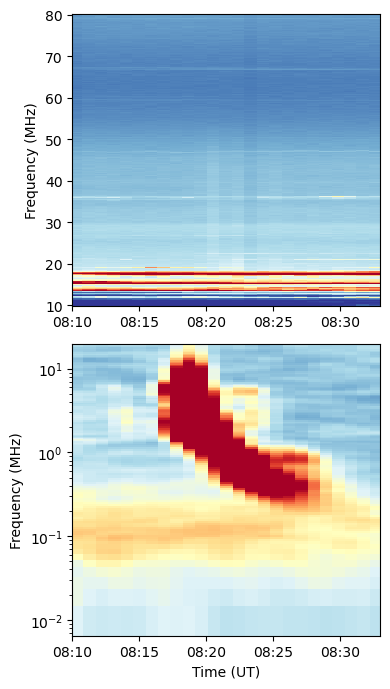

In [165]:
fig = plt.figure(figsize=[4,7])

ax = fig.add_subplot(211)
ax.pcolormesh(nda_resampled.columns,
              nda_resampled.index,
              nda_resampled.values,
              norm=nda_norm,
              cmap='RdYlBu_r')
# ax.set_yscale('log')
ax.set_ylabel('Frequency (MHz)')
# ax.set_title(nda_data[0].header['ORIGIN'] + nda_data[0].header['DATE-OBS'])
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(left=pd.Timestamp('2021-09-18 08:10'), right=pd.Timestamp('2021-09-18 08:33'))

ax = fig.add_subplot(212)
ax.pcolormesh(df_psp.columns,
               df_psp.index,
               df_psp.values,
               norm=psp_norm,
               cmap='RdYlBu_r')
ax.set_yscale('log')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
# ax.grid()
# ax.minorticks_on()
# ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
# ax.xaxis.set_minor_locator(AutoMinorLocator(n=15))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(left=pd.Timestamp('2021-09-18 08:10'), right=pd.Timestamp('2021-09-18 08:33'))

fig.tight_layout()
plt.show()

### Shifting PSP data to match NDA

In [180]:
# psp_struct = pd.DataFrame(df_psp.values.T)
# psp_struct.insert(loc=0, column='DateTime', value=tm_lfr)
# psp_struct.set_index(['DateTime'], inplace=True)

# psp_shift = psp_struct.shift(periods=round((EM_t_travel_earth-EM_t_travel_psp)/psp_cadence), fill_value=0)
psp_shift = df_psp.T.shift(periods=round(t_psp_earth[0]/psp_cadence), fill_value=0)

print(f'PSP frequency range: {psp_shift.columns[0]*1e3:.2f} kHz - {psp_shift.columns[-1]:.2f} MHz')
print(f'NDA frequency range: {nda_resampled.index[0]:.2f} MHz - {nda_resampled.index[-1]:.2f} MHz')

PSP frequency range: 10.55 kHz - 19.17 MHz
NDA frequency range: 10.00 MHz - 80.00 MHz


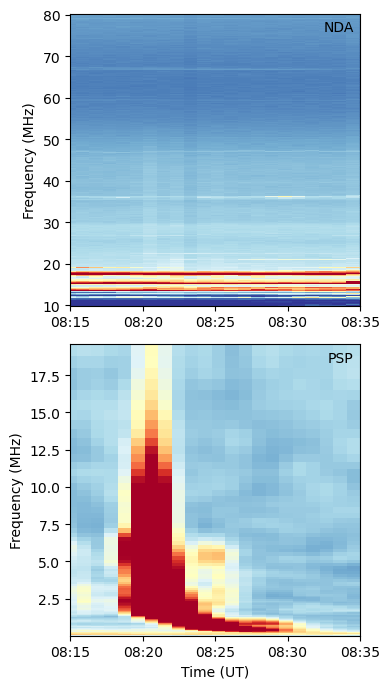

In [244]:
fig = plt.figure(figsize=[4,7])

ax = fig.add_subplot(211)
ax.pcolormesh(nda_resampled.columns,
              nda_resampled.index,
              nda_resampled.values,
              norm=nda_norm,
              cmap='RdYlBu_r')
ax.text(nda_resampled.columns[52], nda_resampled.index[-1]-3, 'NDA', color='black', fontsize=10, ha='center', va='center')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(left=pd.Timestamp('2021-09-18 08:15'), right=pd.Timestamp('2021-09-18 08:35'))

ax = fig.add_subplot(212)
ax.pcolormesh(psp_shift.index,
               psp_shift.columns,
               psp_shift.T.values,
               norm=psp_norm,
               cmap='RdYlBu_r')
ax.text(psp_shift.index[551], psp_shift.columns[-1]-0.5, 'PSP', color='black', fontsize=10, ha='center', va='center')
# ax.set_yscale('log')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(left=pd.Timestamp('2021-09-18 08:15'), right=pd.Timestamp('2021-09-18 08:35'))

fig.tight_layout()
plt.show()

In [213]:
print(nda_resampled.isnull().sum().sum())  # Check for NaNs

0


In [236]:
psp_shift.shape

(1545, 126)

In [140]:
# # clean the NDA data --> Not necessary
# df_nda = pd.DataFrame(nda_arr.astype('float64'))
# # timestamps = [mdates.date2num(t) for t in datetimes_list]
# # df_nda.columns = pd.to_datetime(timestamps, origin='unix', unit='D')
# df_nda.columns = pd.to_datetime(datetimes_list)
# df_nda.insert(loc=0, column='Frequency', value=list(nda_freq))
# df_nda.set_index(['Frequency'], inplace=True)

# # Calculate the mean value in each row (freq channel)
# df_nda_mean = df_nda.mean(axis=0)
# # subtract it from each corresponding row
# df_nda_submean = df_nda.sub(df_nda_mean, axis=1)
# # Check for NaN or infinite values and replace them with zero
# df_nda_submean.replace([-np.inf, np.nan, np.inf], 0, inplace=True)
# df_nda_submean.columns = pd.to_datetime(df_nda_submean.columns)

# fig = plt.figure(figsize=[10,4])
# ax = fig.add_subplot(111)
# ax.pcolormesh(df_nda_submean.columns,
#               df_nda_submean.index,
#               df_nda_submean.values,
#               vmin=np.percentile(df_nda_submean, 1),
#               vmax=np.percentile(df_nda_submean, 95),
#               cmap='RdYlBu_r')
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.set_title(nda_data[0].header['ORIGIN'] + nda_data[0].header['DATE-OBS'])
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# ax.set_xlim(left=pd.Timestamp('2021-09-18 08:00'), right=pd.Timestamp('2021-09-18 09:00'))
# fig.tight_layout()
# plt.show()

In [174]:
# Doing a for loop ...
for col in df.columns:
    print(f'Doing {col} ...')
    
    fig = plt.figure(figsize=[15,11])

    ax = fig.add_subplot(311)
    line94, = ax.plot(df_94.index, df_94[col], color='k', label='AIA 94 $\AA$')
    axx = ax.twinx()
    line193, = axx.plot(df_193.index, df_193[col], color='r', label='AIA 193 $\AA$')
    axx.tick_params(axis='y', colors='r') # Set y-axis tick labels color to match line color
    lines = [line94, line193] # Combine legends
    labels = [line.get_label() for line in lines]
    ax.legend(lines, labels, loc='upper left')
    ax.set_ylabel(f'<int.> {col} (ct/s)')
    ax.grid(alpha=0.5)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.set_xlim(df_193.index[0], df_193.index[-1])

    ax = fig.add_subplot(312)
    for channel in channels:
        ax.plot(df_psp.columns, df_psp.loc[channel], label=f'{channel:.3f} MHz')
    ax.legend()
    ax.grid(alpha=0.5)
    ax.set_ylabel('Signal strength')
    ax.set_title(f"PSP/FIELDS: {df_psp.index[0]*1e3:.2f} kHz $-$ {df_psp.index[-1]:.2f} MHz")
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.set_xlim(df_psp.columns[0], df_psp.columns[-1])
    
    ax = fig.add_subplot(313)
    ax.pcolormesh(df_psp.columns,
                   df_psp.index,
                   df_psp.values,
                   norm=psp_norm,
                   cmap='RdYlBu_r')
    for channel in channels:
        ax.axhline(y=channel, color='white', linestyle='--')

    ax.set_yscale('log')
    ax.set_xlabel('Time (UT)')
    ax.set_ylabel('Frequency (MHz)')
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    fig.tight_layout()
    fig.savefig(f'./plots/psp_comparison_{t.date()}_{col}_{aia_channel}a.png', format='png', dpi=300, bbox_inches='tight')
    plt.close()

Doing avg_int_seg1 ...
Doing avg_int_seg2 ...
Doing avg_int_seg3 ...
Doing avg_int_seg4 ...
Doing avg_int_seg5 ...
Doing avg_int_seg6 ...
Doing avg_int_seg7 ...
Doing avg_int_seg8 ...
Doing avg_int_seg9 ...
Doing avg_int_seg10 ...
Doing avg_int_seg11 ...
Doing avg_int_seg12 ...
Doing avg_int_seg13 ...
Doing avg_int_seg14 ...
Doing avg_int_seg15 ...
Doing avg_int_seg16 ...
